# Dissolve

In [1]:
import geopandas
import starepandas
import numpy
import pystare
import matplotlib.pyplot as plt
import datetime
import multiprocessing

In [2]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world['geom_simple'] = world.simplify(0.002)
#us.set_geometry('geom_simple', inplace=True)

In [3]:
world = starepandas.STAREDataFrame(world, add_stare=True, level=8, add_trixels=True, n_workers=62)

In [4]:
germany = world[world.name=='Germany']
#starepandas.stare_from_geoseries(germany.geometry, level=8, convex=True, force_ccw=True, n_workers=1)

In [5]:
import pandas
x = [10.1, 20.9] 
y = [55.3, 60.1]
df = pandas.DataFrame({'lat': y, 'lon': x})
sids = starepandas.stare_from_xy_df(df)

In [7]:
import shapely
polygon1 = shapely.geometry.Polygon([(0, 0), (1, 1), (1, 0)])
polygon2 = shapely.geometry.Polygon([(5, 5), (6, 6), (6, 5)])
multipolygon = shapely.geometry.MultiPolygon([polygon1, polygon2])
starepandas.from_shapely(multipolygon, force_ccw=True, level=7)

array([4430697608402436103, 4430767977146613767, 4430803161518702599,
       4430838345890791431, 4430979083379146759, 4431014267751235591,
       4431084636495413255, 4417221993892413447, 4417257178264502279,
       4417292362636591111, 4417327547008679943, 4417362731380768775,
       4417397915752857607, 4417433100124946439])

In [8]:
sids = [4611686018427387903, 4611686018427387903]

<AxesSubplot:>

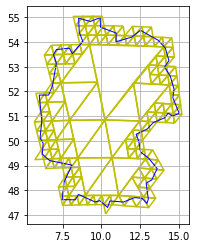

In [9]:
fig, ax = plt.subplots()
ax.grid(True)

country = world[world.name=='Germany']
country.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=0)
country.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)

In [11]:
sids1 = world[world.name=='Germany'].stare.iloc[0]
sids2 = world[world.name=='France'].stare.iloc[0]

## Manual test 1

In [12]:
continent = world[world.continent=='Asia']
continent = world[world.continent=='Africa']
continent = world[(world.name=='Egypt') | (world.name=='Libya') | 
                  (world.name=='Chad') | (world.name=='Sudan') | 
                  (world.name=='Algeria') | (world.name=='Niger') |
                  (world.name=='Nigeria') | (world.name=='Eritrea') ]

continent = world[world.continent=='South America']

In [13]:
sids = numpy.concatenate(list(continent['stare']))
sids = numpy.unique(sids)
s_range = pystare.to_compressed_range(sids)
sids = pystare.expand_intervals(s_range , -1, multi_resolution=True)

df = starepandas.STAREDataFrame(stare=[sids], add_trixels=True)

<AxesSubplot:>

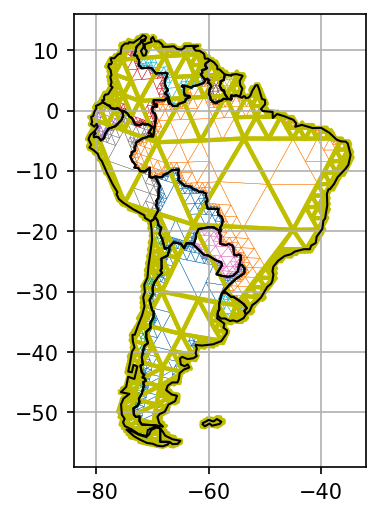

In [14]:
#%matplotlib notebook

fig, ax = plt.subplots(dpi=150)
ax.grid(True)

continent.plot(ax=ax, trixels=True, boundary=True, column='name', zorder=0, linewidth=0.2)
df.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=1, linewidth=2)
continent.plot(ax=ax, facecolor="none", edgecolor='black', zorder=2)

## Manual test 2

In [15]:
def dissolve(sids):
    s_range = pystare.to_compressed_range(sids)
    expanded = pystare.expand_intervals(s_range  , -1, multi_resolution=True)
    return expanded 

def merge_stare(sids, dissolve_sids=True, n_workers=1, n_chunks=1):
    sids = numpy.concatenate(list(sids))    
    dissolved = numpy.unique(sids)
    
    if dissolve_sids==False:
        return list(dissolved)
    
    if n_workers==1 and n_chunks==1:
        dissolved = dissolve(dissolved)            
    else:        
        if n_workers > 1:
            chunks = numpy.array_split(dissolved, n_workers)
            with multiprocessing.Pool(processes=n_workers) as pool:
                dissolved = pool.map(dissolve, chunks)
        elif n_chunks > 1:
            chunks = numpy.array_split(dissolved, n_chunks)
            dissolved = []
            for chunk in chunks:
                dissolved.append(dissolve(chunk))              
        dissolved = numpy.concatenate(dissolved)
        dissolved = numpy.unique(dissolved)
        dissolved = dissolve(dissolved)
        
    return list(dissolved)

In [16]:
start = datetime.datetime.now()
g = world.groupby(group_keys=True, by='continent')['stare'].agg(merge_stare, dissolve_sids=True)
sdf = starepandas.STAREDataFrame(g, stare='stare')
print(datetime.datetime.now()-start)
sdf

0:01:17.446401


,stare
continent,
Africa,"[2814749767106567, 2858730232217608, 286752632..."
Antarctica,"[1911778041818775558, 1911918779307130887, 191..."
Asia,"[288230376151711747, 299489375220137990, 29963..."
Europe,"[648518346341351430, 648659083829706758, 64883..."
North America,"[1171498853069750279, 1171613202279038984, 117..."
Oceania,"[153122387330596869, 153702929470062600, 15372..."
Seven seas (open ocean),"[507358645520957447, 507393829893046279, 50744..."
South America,"[1807104534854500360, 1807113330947522568, 180..."


In [17]:
aggregated_data = world.drop(columns=['stare', 'trixels'], errors='ignore').groupby(by='continent').agg('first')
aggregated_data

,pop_est,name,iso_a3,gdp_md_est,geometry,geom_simple
continent,,,,,,
Africa,53950935,Tanzania,TZA,150600.0,"POLYGON ((33.904 -0.950, 34.073 -1.060, 37.699...","POLYGON ((33.904 -0.950, 34.073 -1.060, 37.699..."
Antarctica,4050,Antarctica,ATA,810.0,"MULTIPOLYGON (((-48.661 -78.047, -48.151 -78.0...","MULTIPOLYGON (((-48.661 -78.047, -48.151 -78.0..."
Asia,18556698,Kazakhstan,KAZ,460700.0,"POLYGON ((87.360 49.215, 86.599 48.549, 85.768...","POLYGON ((87.360 49.215, 86.599 48.549, 85.768..."
Europe,142257519,Russia,RUS,3745000.0,"MULTIPOLYGON (((178.725 71.099, 180.000 71.516...","MULTIPOLYGON (((178.725 71.099, 180.000 71.516..."
North America,35623680,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.840 49.000, -122.974 49.0...","MULTIPOLYGON (((-122.840 49.000, -122.974 49.0..."
Oceania,920938,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.000 -16.067, 180.000 -16.5...","MULTIPOLYGON (((180.000 -16.067, 180.000 -16.5..."
Seven seas (open ocean),140,Fr. S. Antarctic Lands,ATF,16.0,"POLYGON ((68.935 -48.625, 69.580 -48.940, 70.5...","POLYGON ((68.935 -48.625, 69.580 -48.940, 70.5..."
South America,44293293,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.634 -52.636, -68.250 -53.1...","MULTIPOLYGON (((-68.634 -52.636, -68.250 -53.1..."


In [18]:
aggregated = sdf.join(aggregated_data)
aggregated

,stare,pop_est,name,iso_a3,gdp_md_est,geometry,geom_simple
continent,,,,,,,
Africa,"[2814749767106567, 2858730232217608, 286752632...",53950935,Tanzania,TZA,150600.0,"POLYGON ((33.904 -0.950, 34.073 -1.060, 37.699...","POLYGON ((33.904 -0.950, 34.073 -1.060, 37.699..."
Antarctica,"[1911778041818775558, 1911918779307130887, 191...",4050,Antarctica,ATA,810.0,"MULTIPOLYGON (((-48.661 -78.047, -48.151 -78.0...","MULTIPOLYGON (((-48.661 -78.047, -48.151 -78.0..."
Asia,"[288230376151711747, 299489375220137990, 29963...",18556698,Kazakhstan,KAZ,460700.0,"POLYGON ((87.360 49.215, 86.599 48.549, 85.768...","POLYGON ((87.360 49.215, 86.599 48.549, 85.768..."
Europe,"[648518346341351430, 648659083829706758, 64883...",142257519,Russia,RUS,3745000.0,"MULTIPOLYGON (((178.725 71.099, 180.000 71.516...","MULTIPOLYGON (((178.725 71.099, 180.000 71.516..."
North America,"[1171498853069750279, 1171613202279038984, 117...",35623680,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.840 49.000, -122.974 49.0...","MULTIPOLYGON (((-122.840 49.000, -122.974 49.0..."
Oceania,"[153122387330596869, 153702929470062600, 15372...",920938,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.000 -16.067, 180.000 -16.5...","MULTIPOLYGON (((180.000 -16.067, 180.000 -16.5..."
Seven seas (open ocean),"[507358645520957447, 507393829893046279, 50744...",140,Fr. S. Antarctic Lands,ATF,16.0,"POLYGON ((68.935 -48.625, 69.580 -48.940, 70.5...","POLYGON ((68.935 -48.625, 69.580 -48.940, 70.5..."
South America,"[1807104534854500360, 1807113330947522568, 180...",44293293,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.634 -52.636, -68.250 -53.1...","MULTIPOLYGON (((-68.634 -52.636, -68.250 -53.1..."


## High level functions

In [19]:
world.stare_dissolve(by='continent', aggfunc='sum')

,stare,pop_est,gdp_md_est
continent,,,
Africa,"[2814749767106567, 2858730232217608, 286752632...",1219176238,6025295.50
Antarctica,"[1911778041818775558, 1911918779307130887, 191...",4050,810.00
Asia,"[288230376151711747, 299489375220137990, 29963...",4389144868,55434607.77
Europe,"[648518346341351430, 648659083829706758, 64883...",746398461,25284877.00
North America,"[1171498853069750279, 1171613202279038984, 117...",573042112,23505137.00
Oceania,"[153122387330596869, 153702929470062600, 15372...",36782844,1412885.00
Seven seas (open ocean),"[507358645520957447, 507393829893046279, 50744...",140,16.00
South America,"[1807104534854500360, 1807113330947522568, 180...",418540749,6377091.80


In [20]:
world.dissolve(by='continent', aggfunc='sum')

,geometry,pop_est,gdp_md_est
continent,,,
Africa,"MULTIPOLYGON (((32.830 -26.742, 32.580 -27.470...",1219176238,6025295.50
Antarctica,"MULTIPOLYGON (((-163.713 -78.596, -163.713 -78...",4050,810.00
Asia,"MULTIPOLYGON (((120.295 -10.259, 118.968 -9.55...",4389144868,55434607.77
Europe,"MULTIPOLYGON (((-51.658 4.156, -52.249 3.241, ...",746398461,25284877.00
North America,"MULTIPOLYGON (((-61.680 10.760, -61.105 10.890...",573042112,23505137.00
Oceania,"MULTIPOLYGON (((169.668 -43.555, 170.525 -43.0...",36782844,1412885.00
Seven seas (open ocean),"POLYGON ((68.935 -48.625, 69.580 -48.940, 70.5...",140,16.00
South America,"MULTIPOLYGON (((-66.960 -54.897, -67.291 -55.3...",418540749,6377091.80
